<a href="https://colab.research.google.com/github/omdena/policy_pandemic/blob/master/task9_policy_correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import scipy
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
df=pd.read_csv('cluster_appended_oxford_data.csv')

In [0]:
sns.set(font_scale=1.4)

#Pearson Correlation

In [0]:
def correlation_mat(df,policies,cluster,globe):
  if globe==True:
    df_temp=df.loc[:,policies]
    cor_mat=df_temp.corr(method='spearman')
    plt.subplots(figsize=(15,10))
    plt.title("Correlation of policies(World)")
    sns.heatmap(cor_mat,linewidths=.5, annot=True, cmap="YlGnBu")
  else:
    df_temp=df.loc[:,policies]
    df_temp=df_temp.loc[df['Cluster']==cluster]
    cor_mat=df_temp.corr(method='spearman')
    plt.subplots(figsize=(15,10))
    plt.title("Correlation of policies in cluster "+ str(cluster))
    sns.heatmap(cor_mat,linewidths=.5, annot=True, cmap="YlGnBu")

In [0]:
df.columns

Index(['CountryName', 'Class', 'Cluster', 'Date', 'C1_School closing',
       'C1_Flag', 'C2_Workplace closing', 'C2_Flag', 'C3_Cancel public events',
       'C3_Flag', 'C4_Restrictions on gatherings', 'C4_Flag',
       'C5_Close public transport', 'C5_Flag', 'C6_Stay at home requirements',
       'C6_Flag', 'C7_Restrictions on internal movement', 'C7_Flag',
       'C8_International travel controls', 'E1_Income support', 'E1_Flag',
       'E2_Debt/contract relief', 'E3_Fiscal measures',
       'E4_International support', 'H1_Public information campaigns',
       'H1_Flag', 'H2_Testing policy', 'H3_Contact tracing',
       'H4_Emergency investment in healthcare', 'H5_Investment in vaccines',
       'ConfirmedCases', 'Daily_confirmed', 'ConfirmedDeaths', 'Daily_deaths',
       'MIR%', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'H1', 'C8',
       'StringencyIndex', 'StringencyIndexForDisplay', 'LegacyStringencyIndex',
       'LegacyStringencyIndexForDisplay'],
      dtype='object')

In [0]:
def cluster_wise_study(df,clusters=[],globe=False):
  if globe==False:
    for c in clusters: 
      correlation_mat(df,['C1_School closing','C2_Workplace closing',
                          'C3_Cancel public events','C4_Restrictions on gatherings',
                          'C5_Close public transport', 'C6_Stay at home requirements',
                          'C7_Restrictions on internal movement',
                          'C8_International travel controls', 'E1_Income support',
                          'E2_Debt/contract relief', 'H1_Public information campaigns',
                          'H2_Testing policy', 'H3_Contact tracing'
                          ],c,globe)
  else:
    correlation_mat(df,['C1_School closing','C2_Workplace closing',
                          'C3_Cancel public events','C4_Restrictions on gatherings',
                          'C5_Close public transport', 'C6_Stay at home requirements',
                          'C7_Restrictions on internal movement',
                          'C8_International travel controls', 'E1_Income support',
                          'E2_Debt/contract relief', 'H1_Public information campaigns',
                          'H2_Testing policy', 'H3_Contact tracing'
                          ],0,globe)

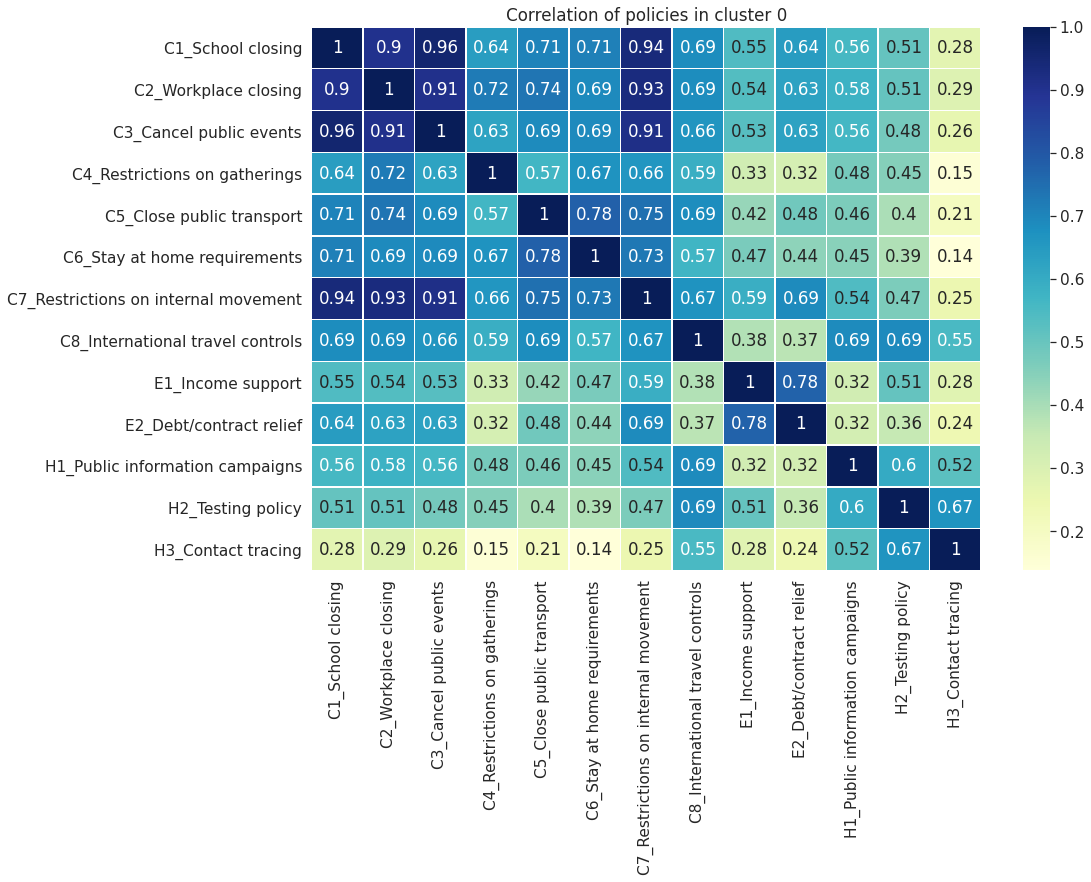

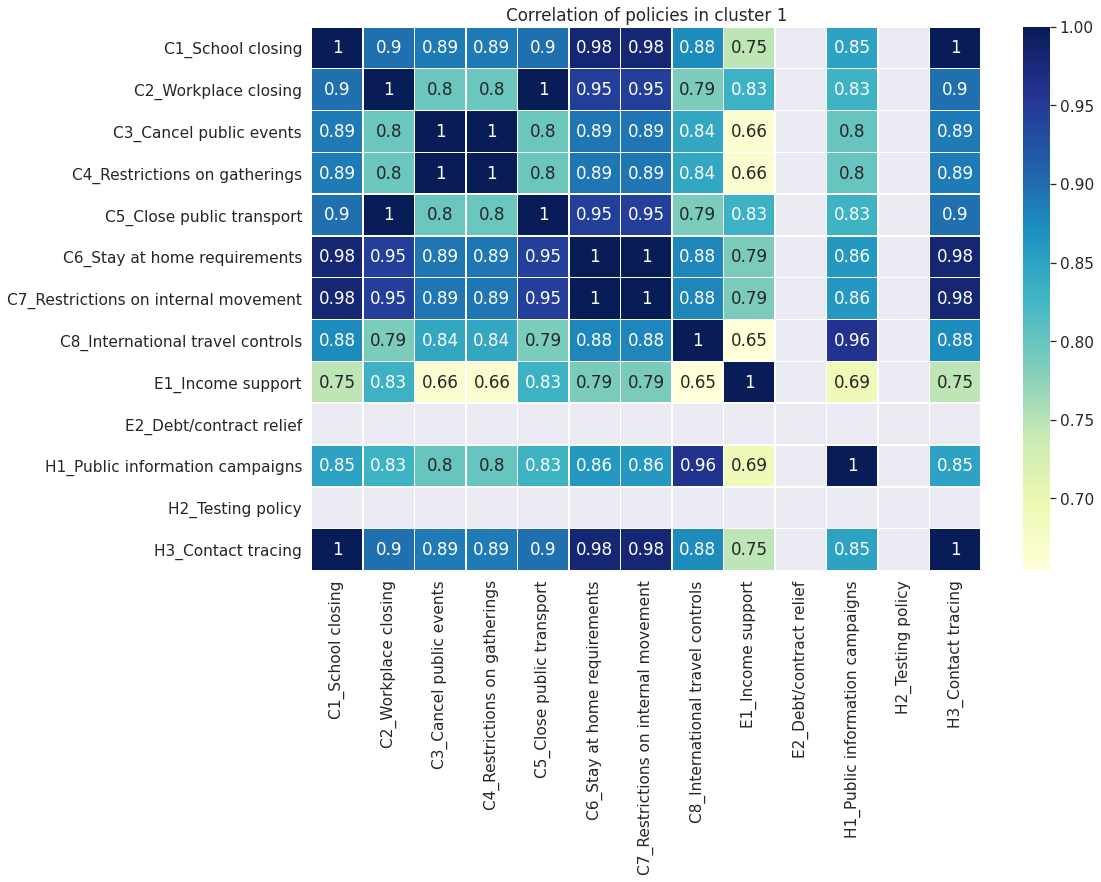

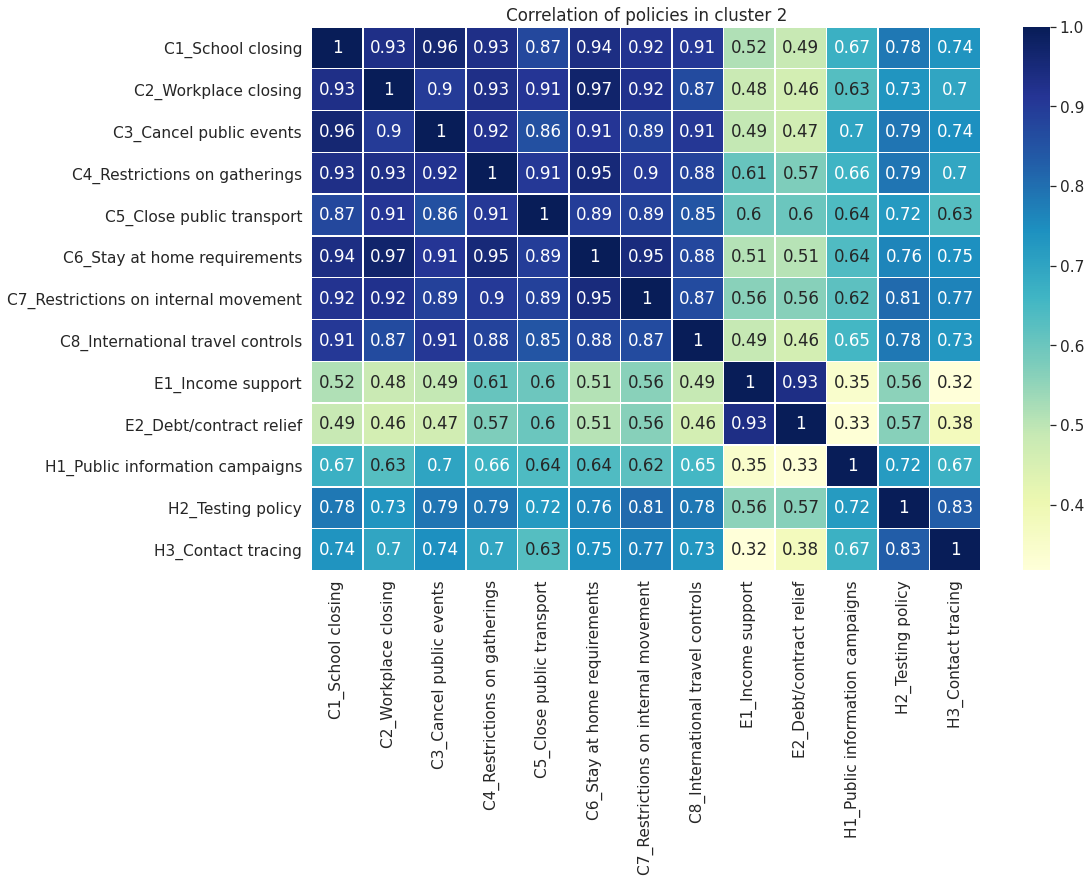

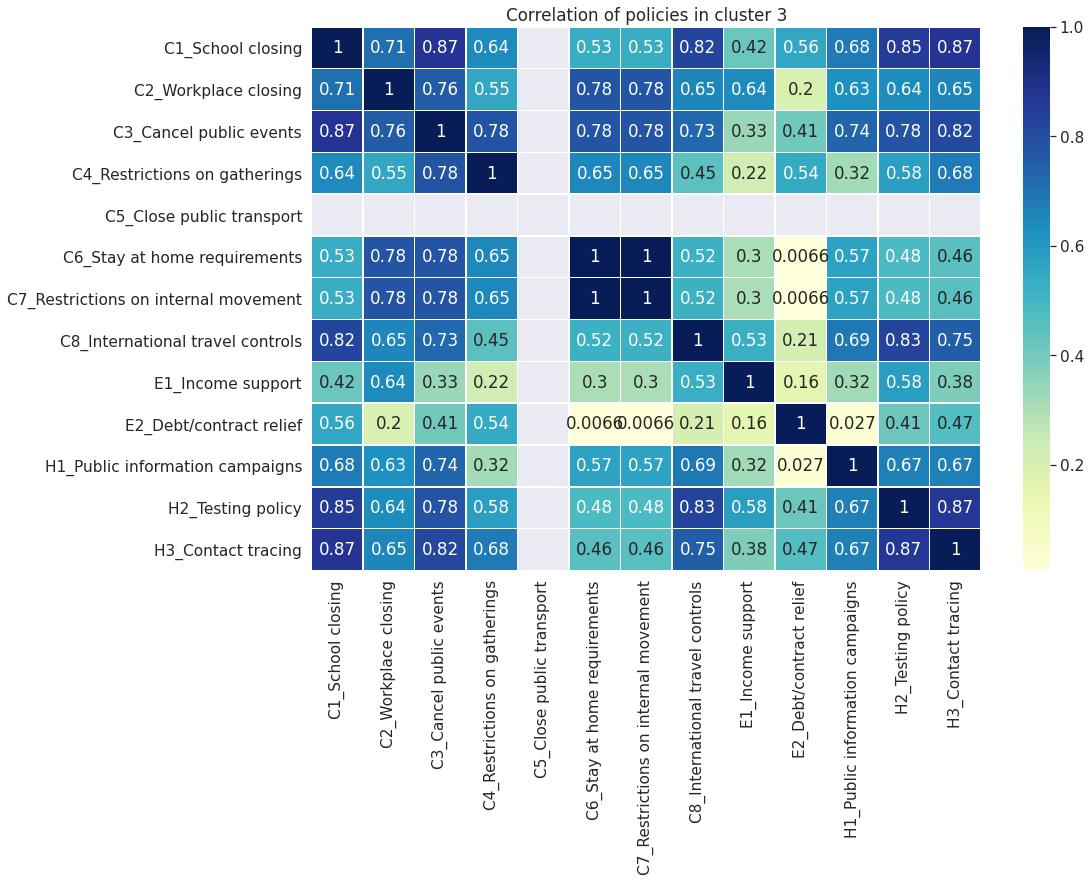

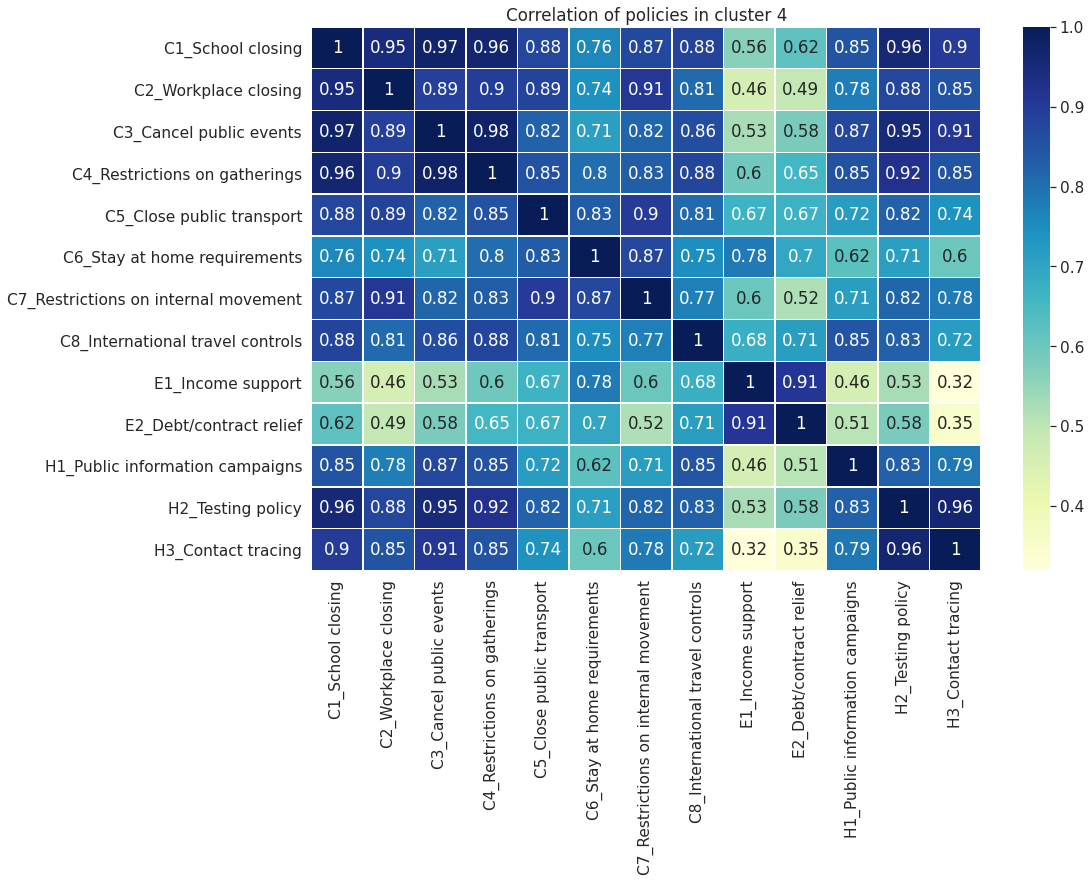

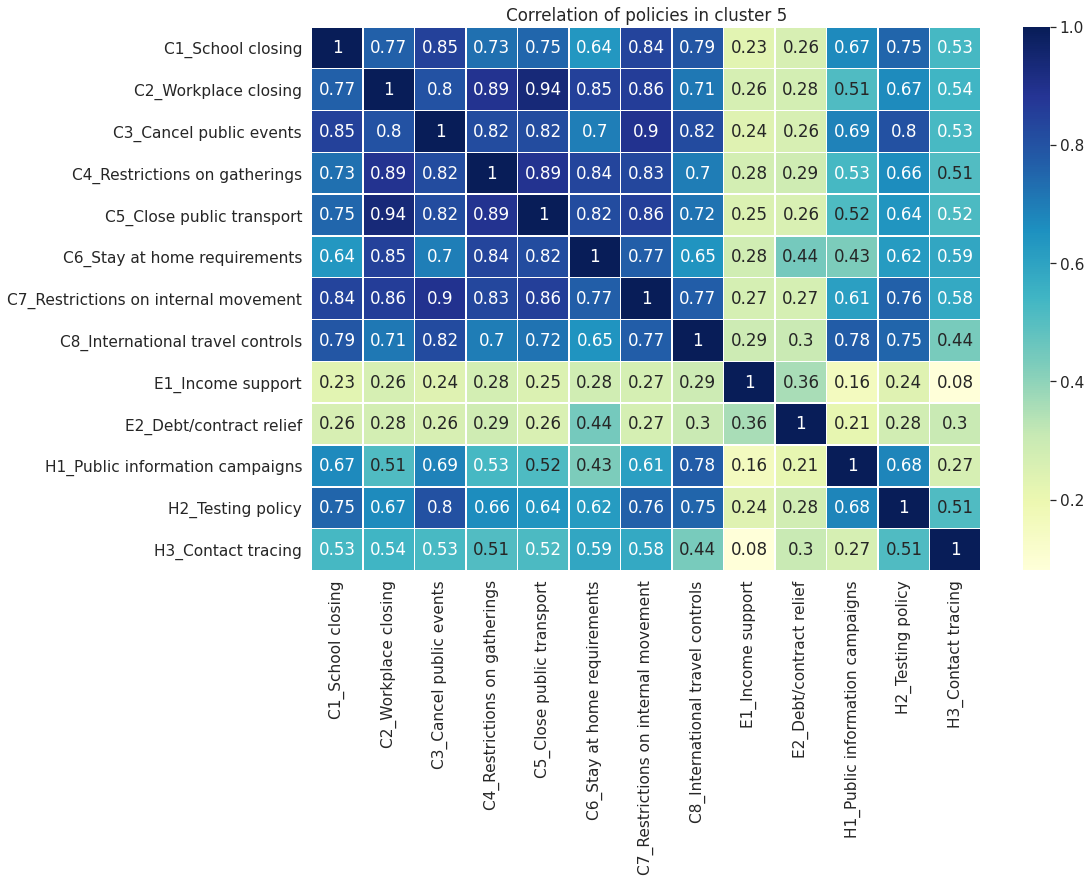

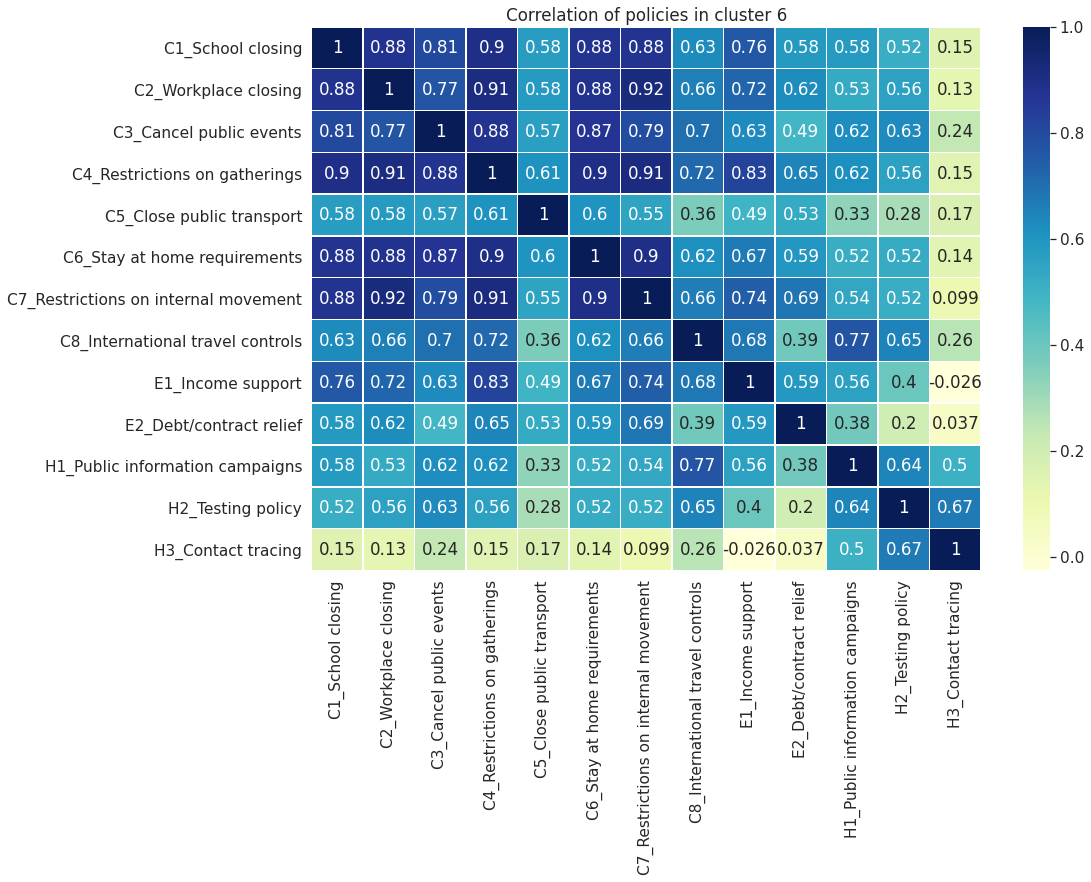

In [0]:
cluster_wise_study(df,range(7))

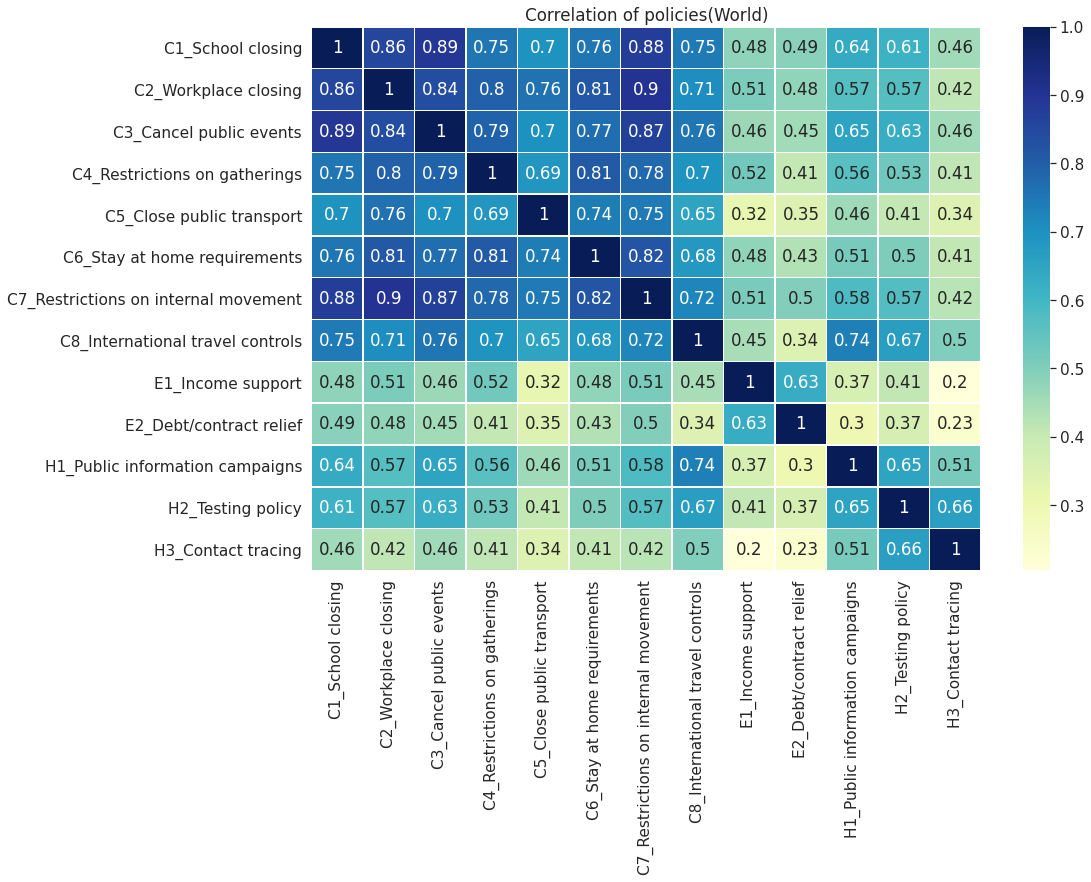

In [0]:
cluster_wise_study(df,[],globe=True)

In [0]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

# Windowed time lagged cross correlation

In [0]:
def WTCC(df,var1,var2,seconds=5,fps=30,no_splits=20):
  samples_per_split = df.shape[0]/no_splits
  rss=[]
  for t in range(0, no_splits):
      d1 = df[var1].loc[(t)*samples_per_split:(t+1)*samples_per_split]
      d2 = df[var2].loc[(t)*samples_per_split:(t+1)*samples_per_split]
      rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
      rss.append(rs)
  rss = pd.DataFrame(rss)
  f,ax = plt.subplots(figsize=(10,5))
  sns.heatmap(rss,cmap='RdBu_r',ax=ax)
  ax.set(title=f'Windowed Time Lagged Cross Correlation \n('+str(var1)+','+str(var2)+')',xlim=[0,301], xlabel='Offset',ylabel='Window epochs')
  ax.set_xticks([0, 50, 100, 151, 201, 251, 301])
  ax.set_xticklabels([-150, -100, -50, 0, 50, 100, 150]);

# Rolling window time lagged cross correlation

In [0]:
def RWTCC(df,var1,var2):
  seconds = 5
  fps = 30
  window_size = 7 #samples
  t_start = 0
  t_end = t_start + window_size
  step_size = 7
  rss=[]
  while t_end < 100:
      d1 = df[var1].iloc[t_start:t_end]
      d2 = df[var2].iloc[t_start:t_end]
      rs = [crosscorr(d1,d2, lag, wrap=False) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
      rss.append(rs)
      t_start = t_start + step_size
      t_end = t_end + step_size
  rss = pd.DataFrame(rss)

  f,ax = plt.subplots(figsize=(10,10))
  sns.heatmap(rss,cmap='RdBu_r',ax=ax)
  ax.set(title=f'Rolling Windowed Time Lagged Cross Correlation',xlim=[0,301], xlabel='Offset',ylabel='Epochs')
  ax.set_xticks([0, 50, 100, 151, 201, 251, 301])
  ax.set_xticklabels([-150, -100, -50, 0, 50, 100, 150]);

# Experiments

In [0]:
df.columns

Index(['CountryName', 'Class', 'Cluster', 'Date', 'C1_School closing',
       'C1_Flag', 'C2_Workplace closing', 'C2_Flag', 'C3_Cancel public events',
       'C3_Flag', 'C4_Restrictions on gatherings', 'C4_Flag',
       'C5_Close public transport', 'C5_Flag', 'C6_Stay at home requirements',
       'C6_Flag', 'C7_Restrictions on internal movement', 'C7_Flag',
       'C8_International travel controls', 'E1_Income support', 'E1_Flag',
       'E2_Debt/contract relief', 'E3_Fiscal measures',
       'E4_International support', 'H1_Public information campaigns',
       'H1_Flag', 'H2_Testing policy', 'H3_Contact tracing',
       'H4_Emergency investment in healthcare', 'H5_Investment in vaccines',
       'ConfirmedCases', 'Daily_confirmed', 'ConfirmedDeaths', 'Daily_deaths',
       'MIR%', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'H1', 'C8',
       'StringencyIndex', 'StringencyIndexForDisplay', 'LegacyStringencyIndex',
       'LegacyStringencyIndexForDisplay'],
      dtype='object')

In [0]:
from itertools import combinations as com
def all_policies_WTCC(df,exclude):
  df=df.drop(columns=exclude)
  list_of_policies=list()
  for i in com(df.columns,2):
    list_of_policies.append(i)
    #print(i)
  #print(len(list_of_policies))
  for pair in list_of_policies:
    WTCC(df,pair[0],pair[1])
  print("Excution Complete!!")

In [0]:
health_metrics=['ConfirmedCases','Daily_confirmed',
                 'Daily_deaths','ConfirmedDeaths',
                 'Daily_deaths','MIR%']
mov_policies=[ 'C1_School closing',
              'C2_Workplace closing', 'C3_Cancel public events',
              'C4_Restrictions on gatherings','C5_Close public transport',
              'C6_Stay at home requirements','C7_Restrictions on internal movement',
              'C8_International travel controls']
exclude=['CountryName','Class','Date','Cluster',
                      'C1_Flag','C2_Flag','C3_Flag','C4_Flag',
                      'C5_Flag','C6_Flag','C7_Flag','E3_Fiscal measures','E1_Flag','H1_Flag',
                      'E4_International support','C1','C2','C3','C4','C5',
                      'C6','C7','H1','C8','LegacyStringencyIndex','StringencyIndexForDisplay',
                      'LegacyStringencyIndexForDisplay','H5_Investment in vaccines',
                      'H4_Emergency investment in healthcare']

Excution Complete!!


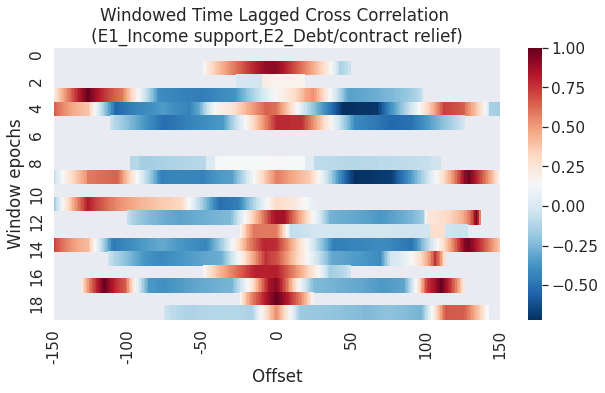

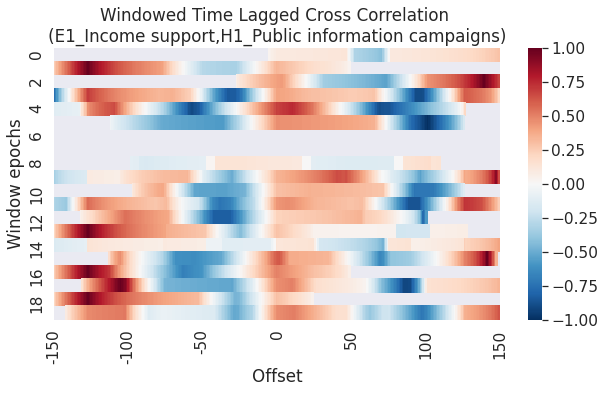

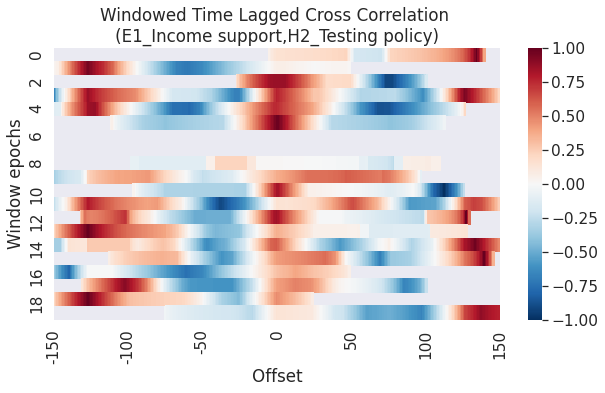

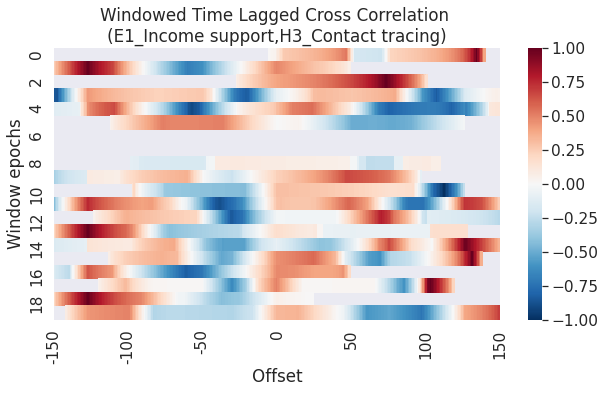

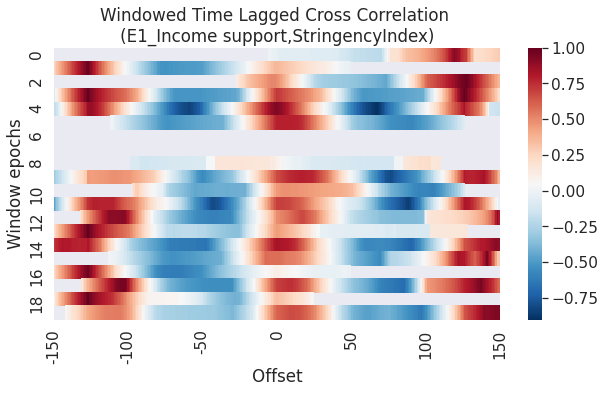

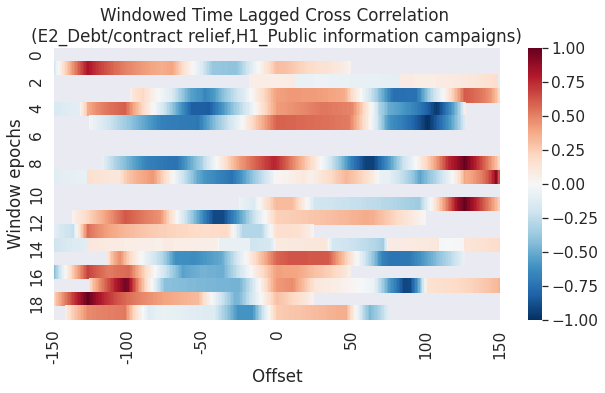

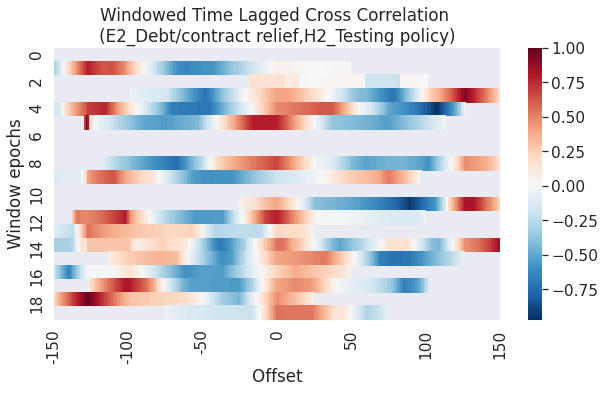

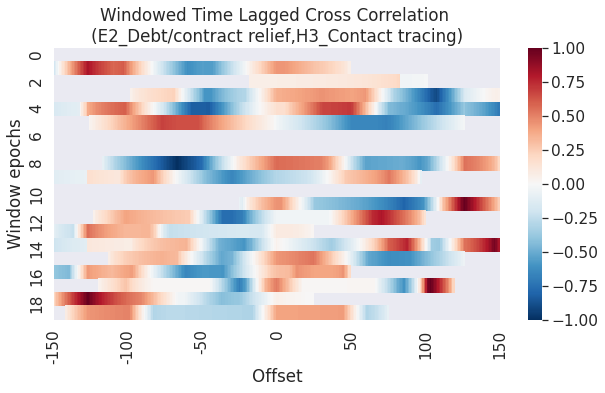

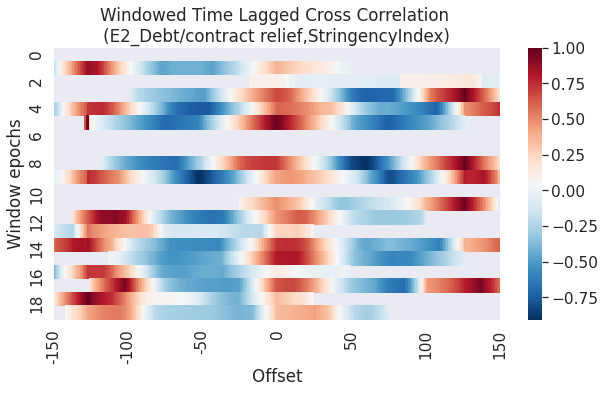

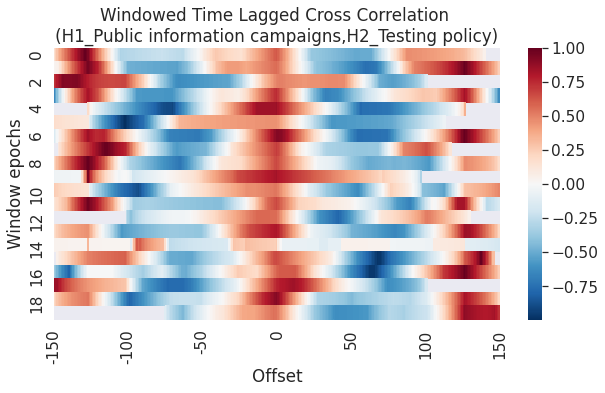

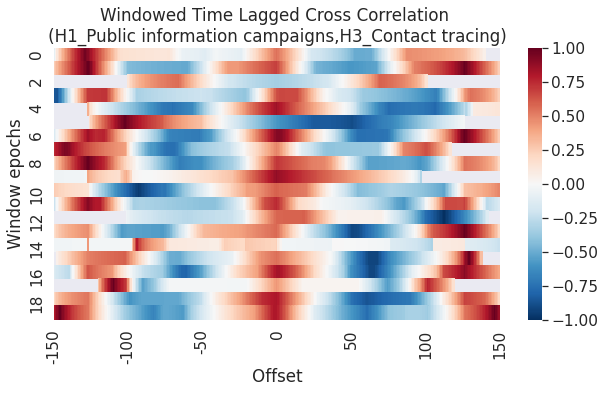

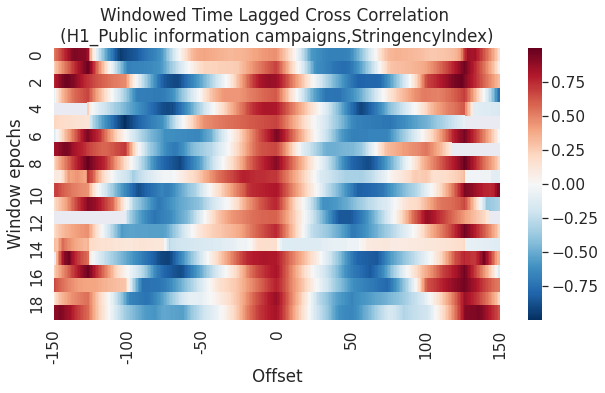

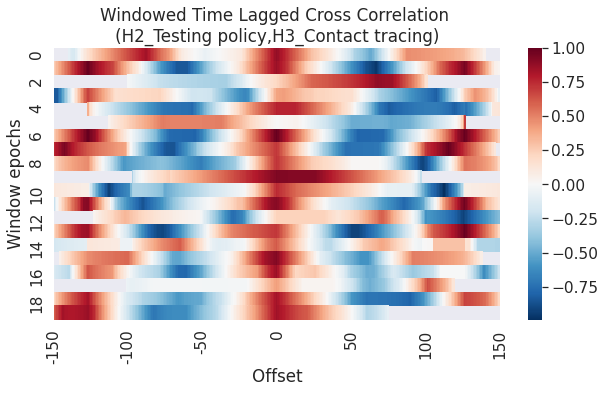

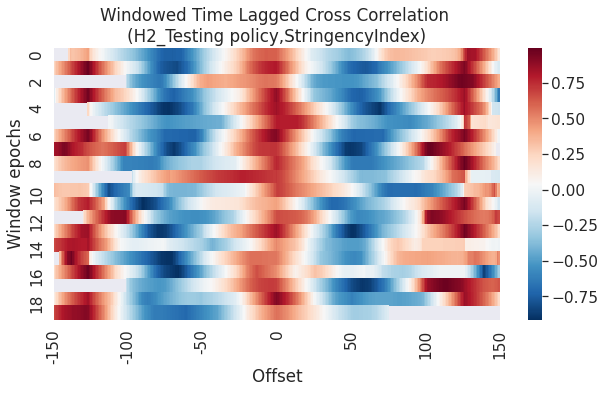

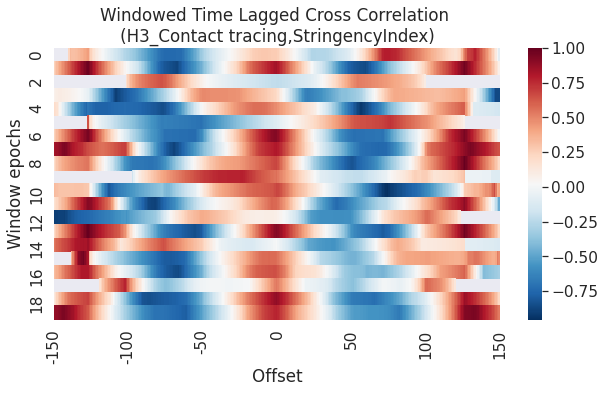

In [0]:
all_policies_WTCC(df,exclude+health_metrics+mov_policies)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


Excution Complete!!


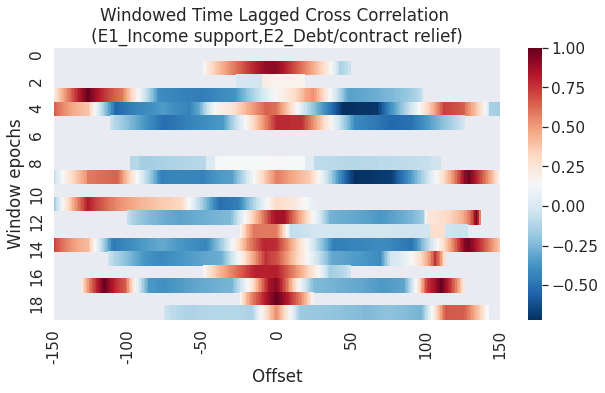

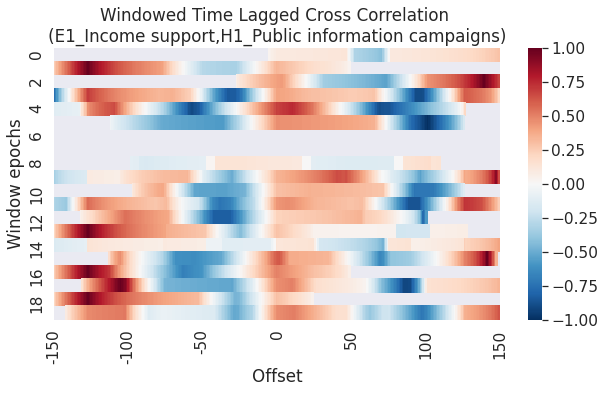

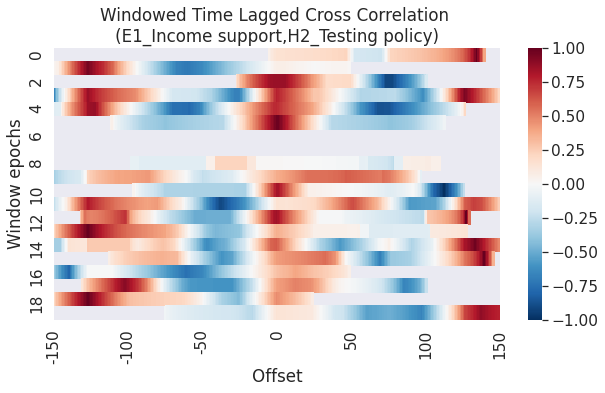

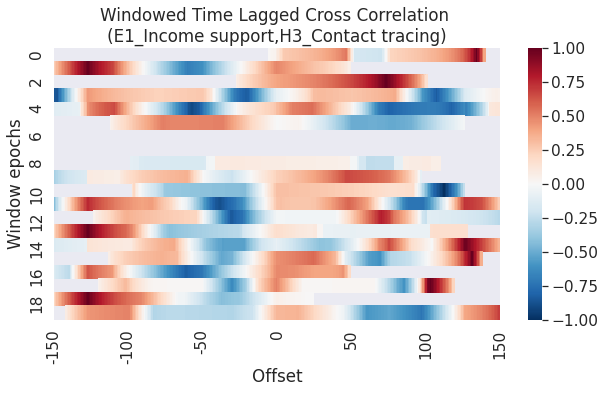

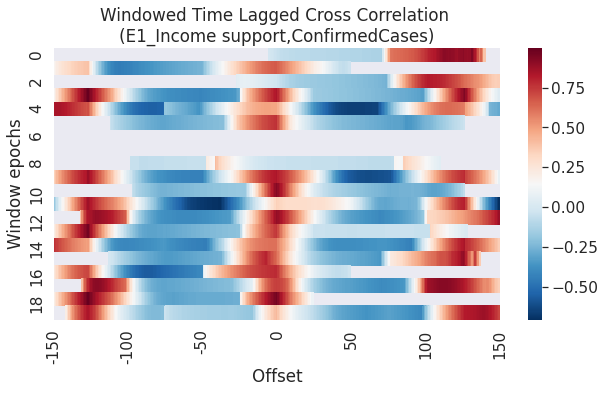

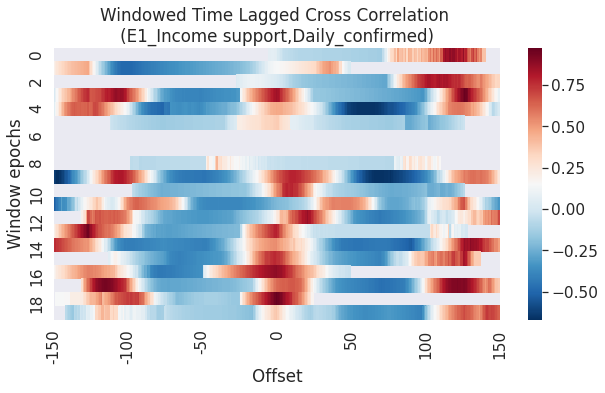

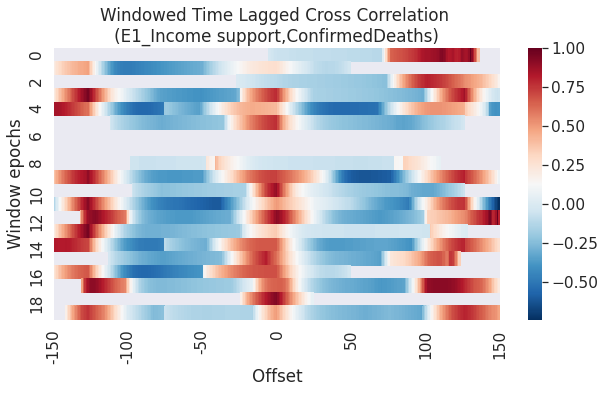

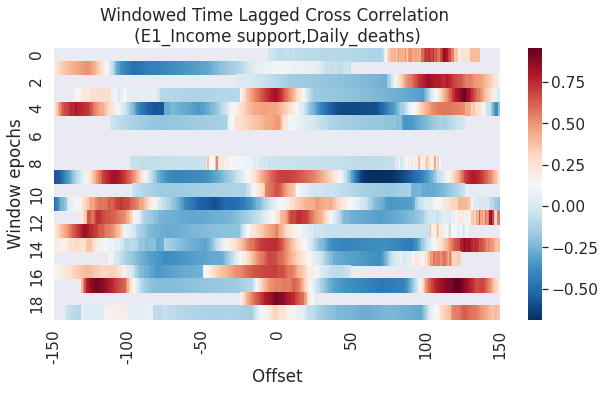

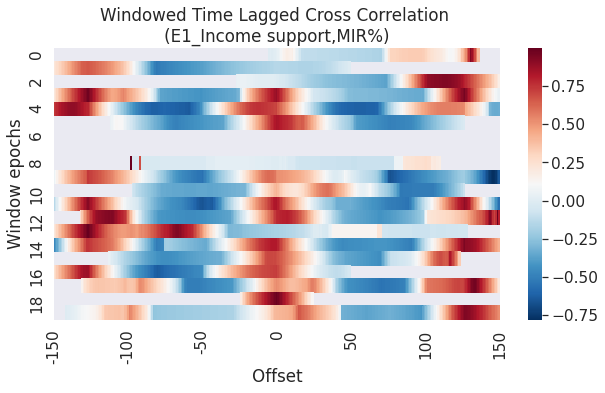

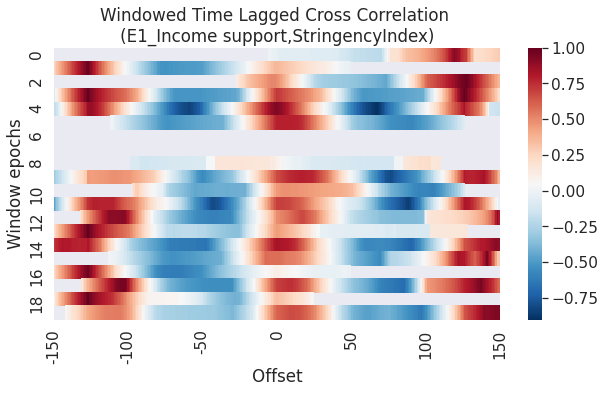

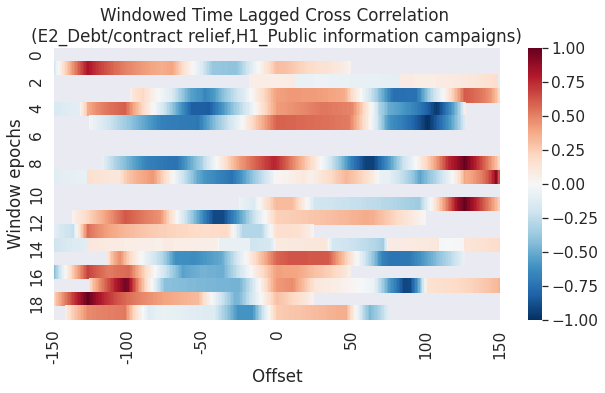

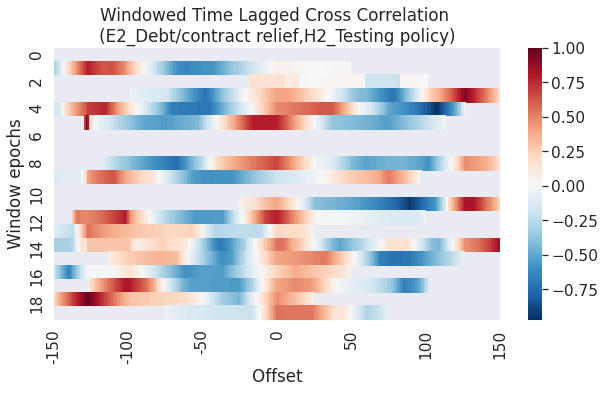

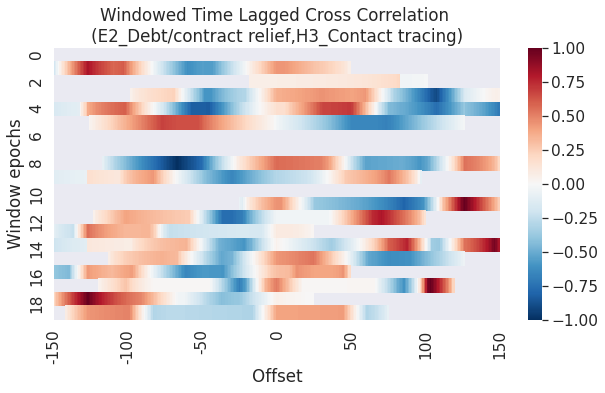

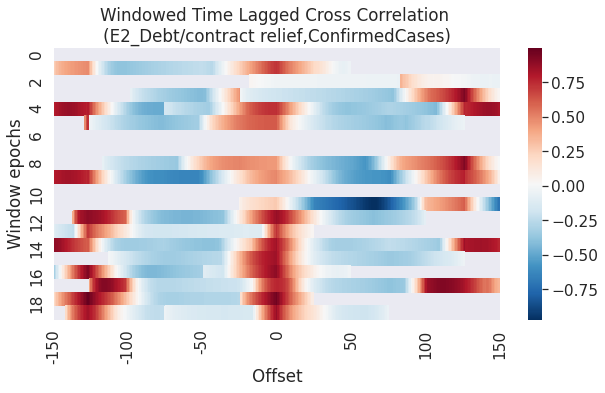

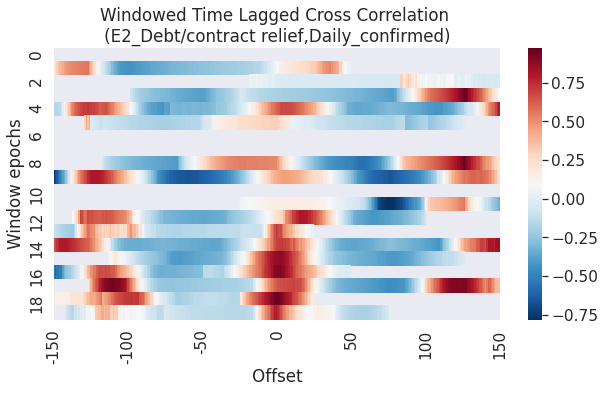

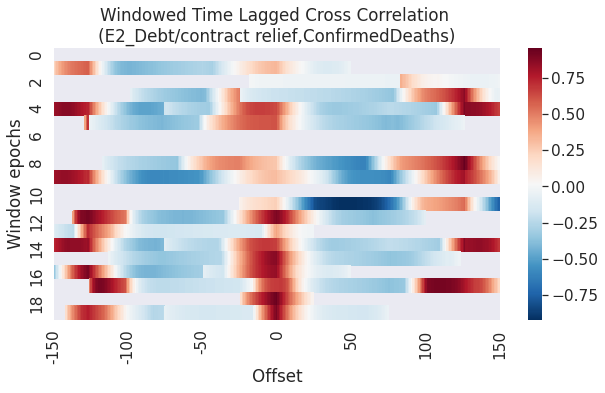

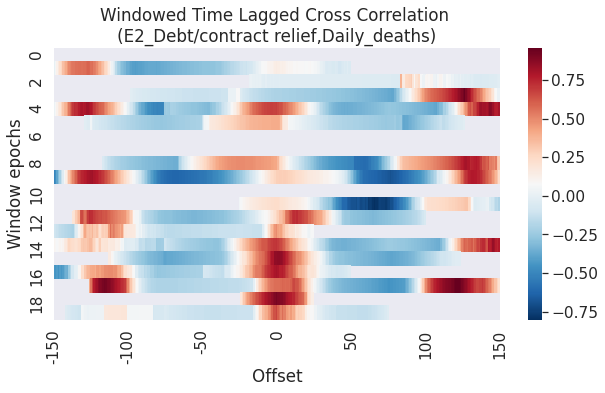

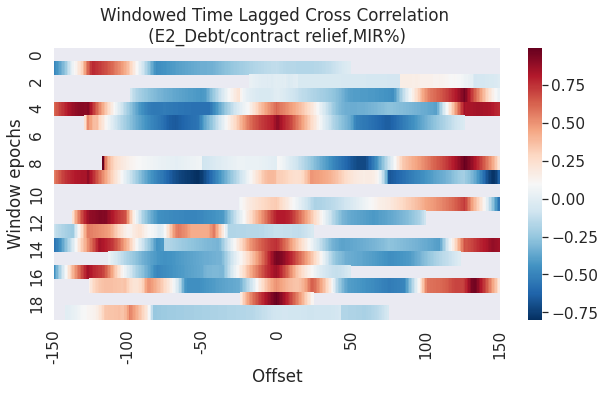

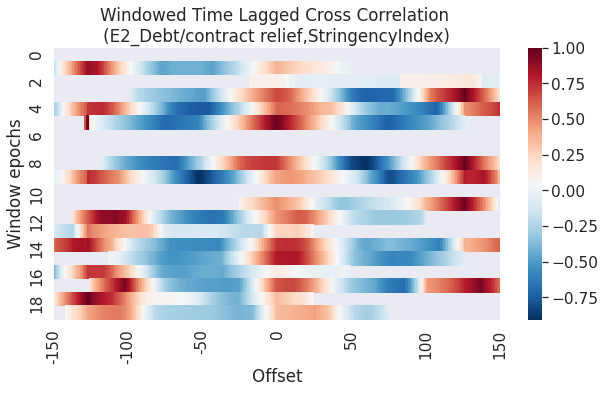

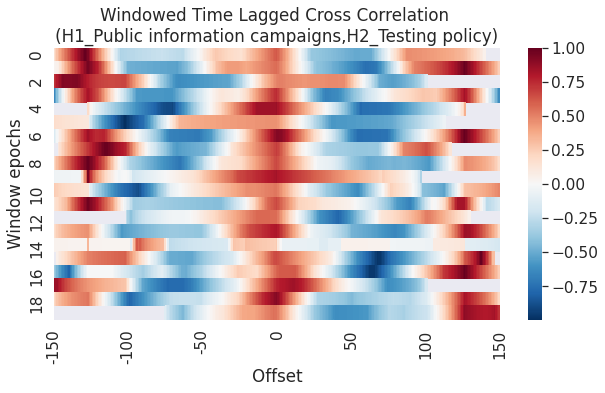

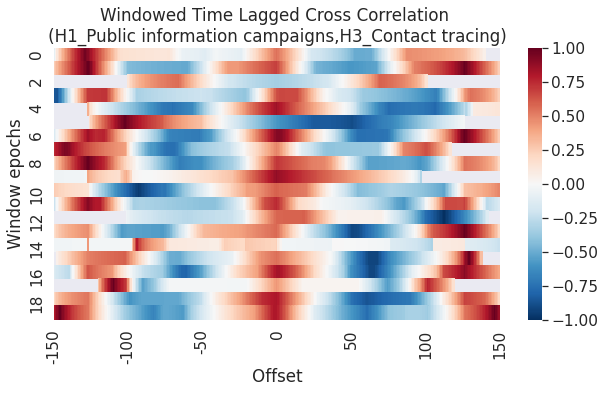

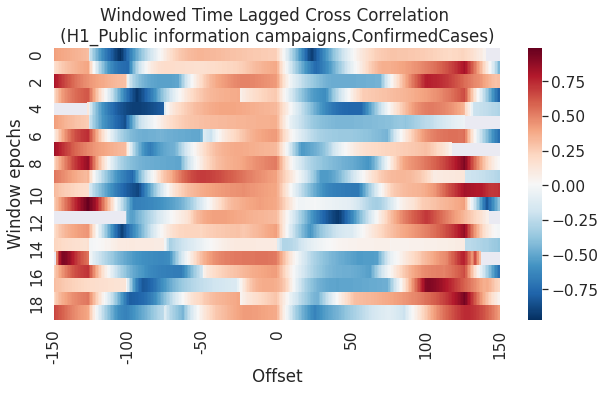

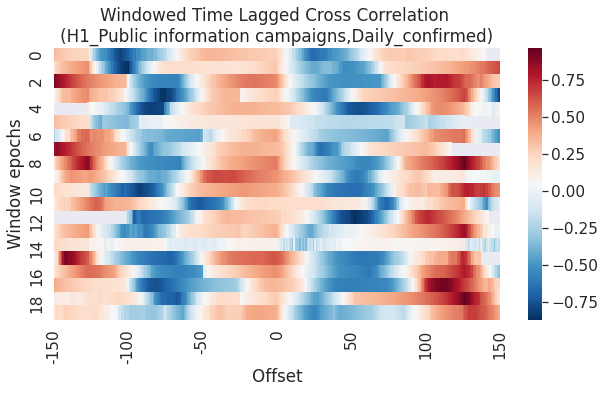

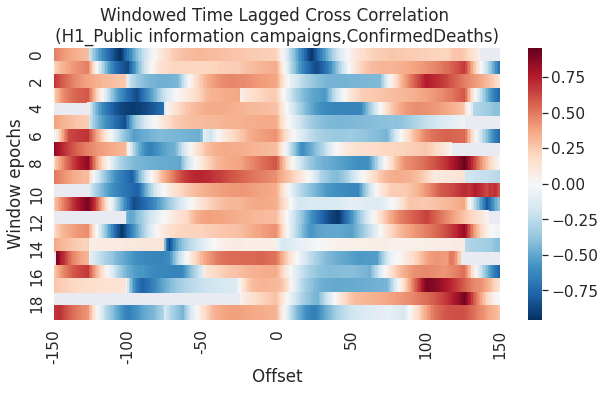

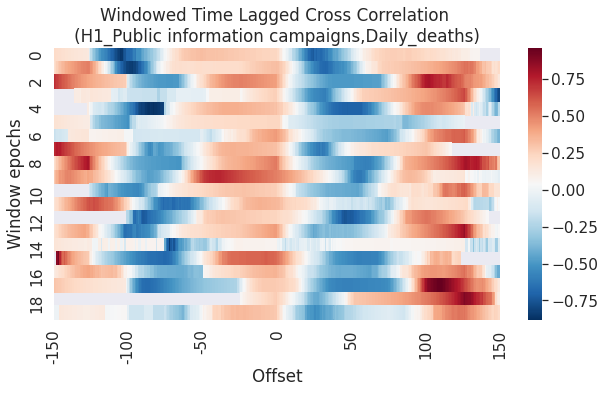

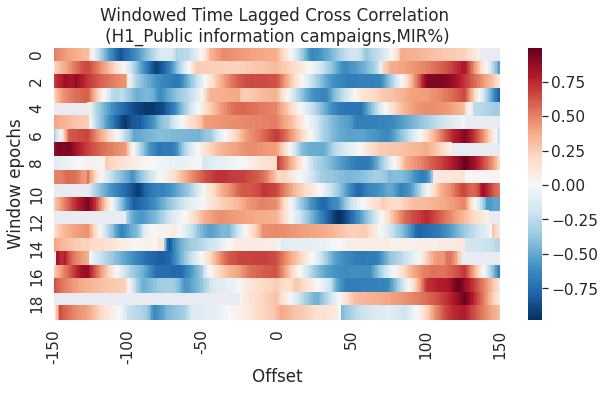

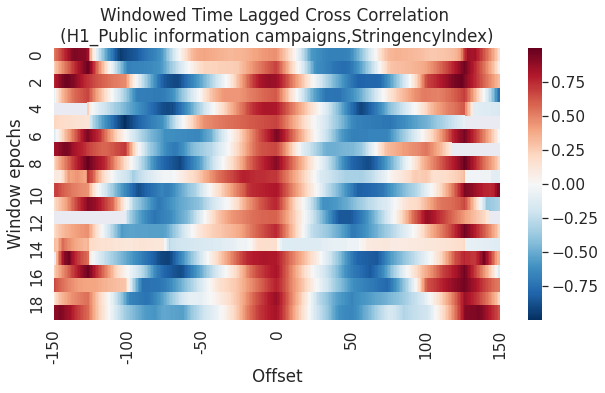

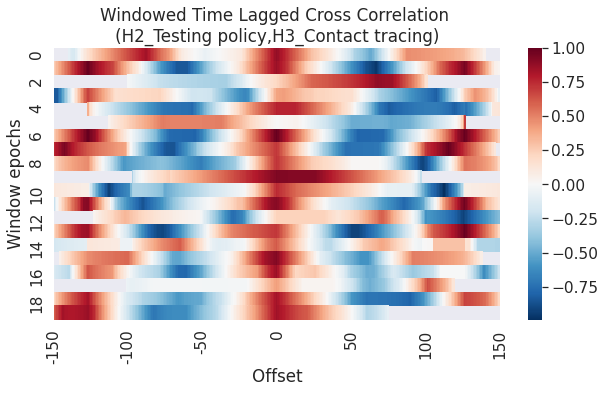

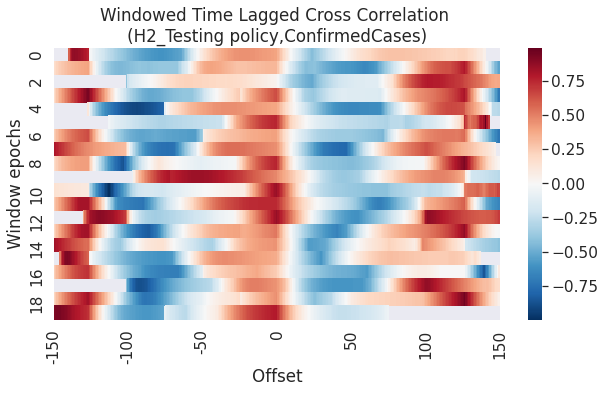

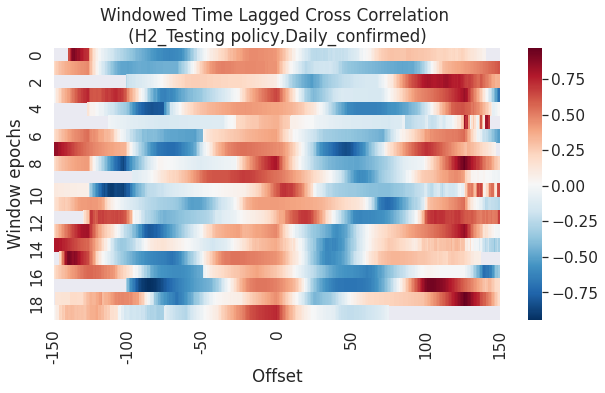

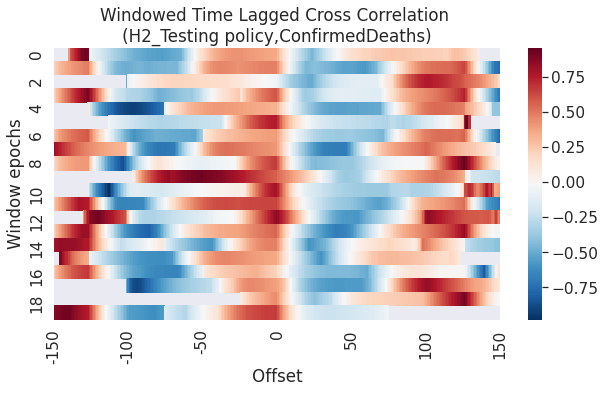

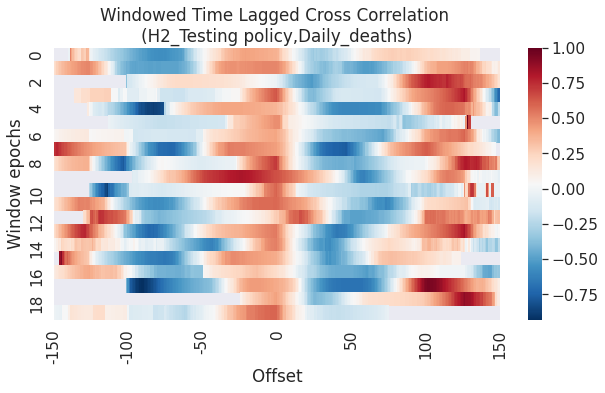

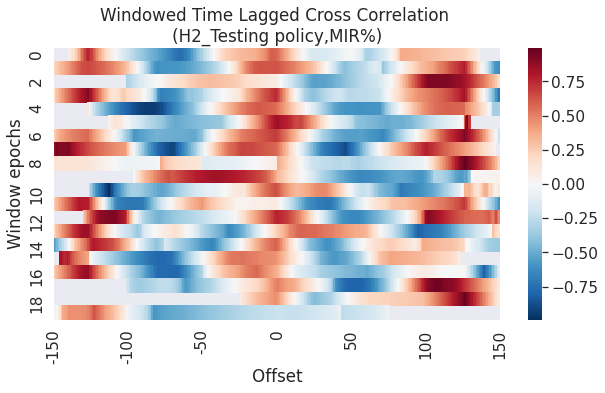

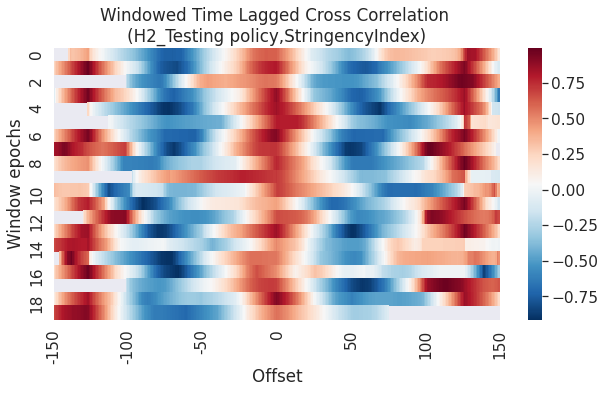

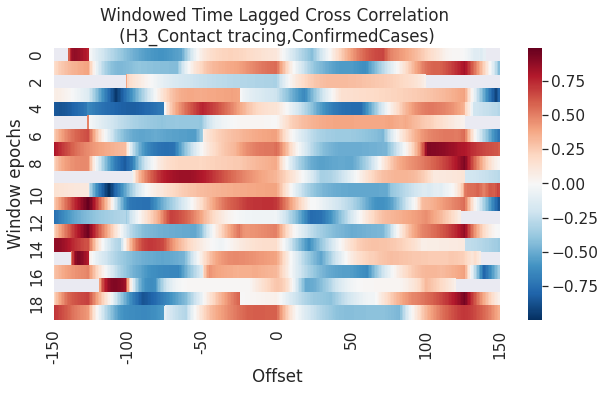

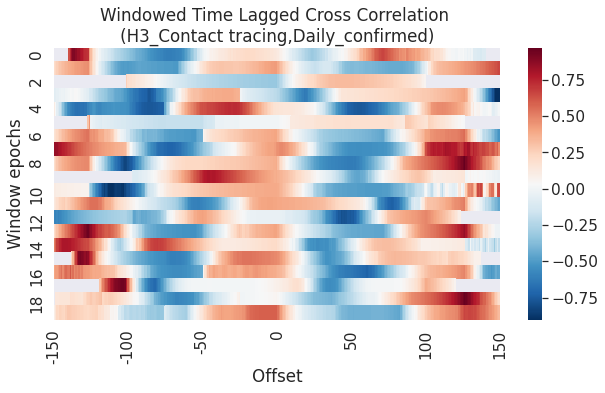

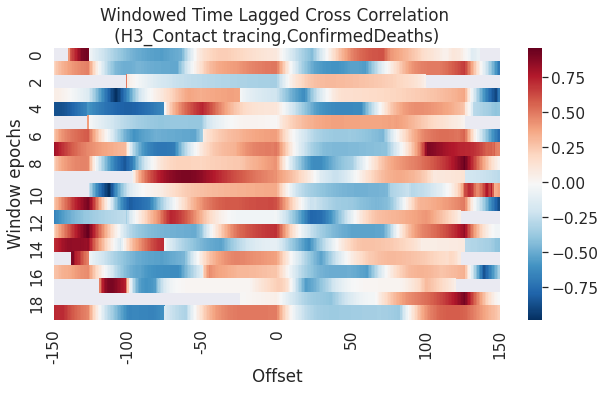

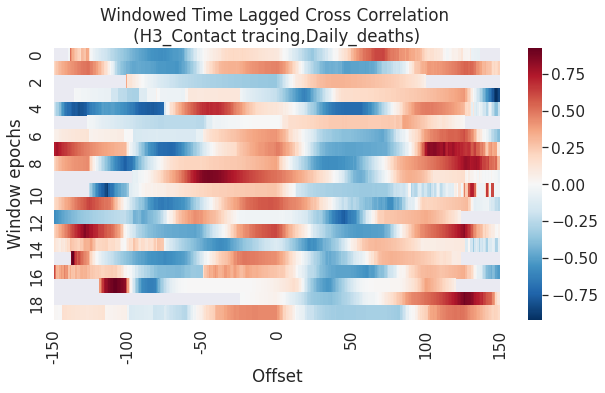

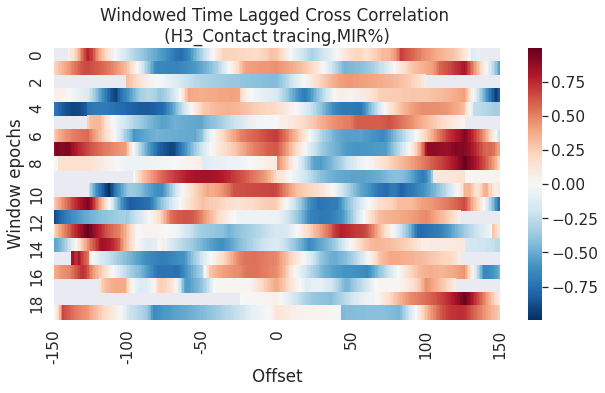

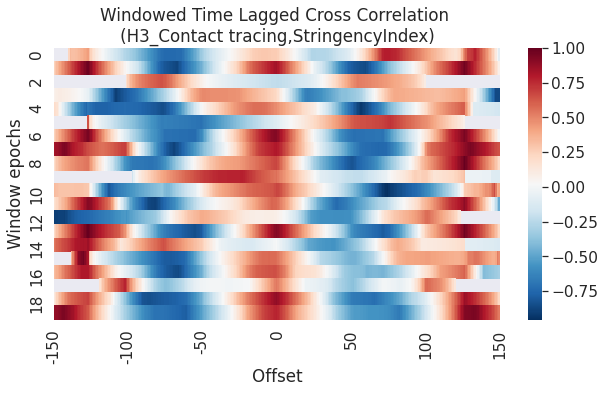

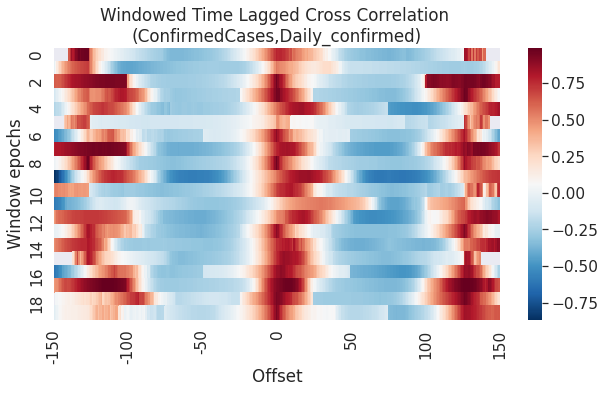

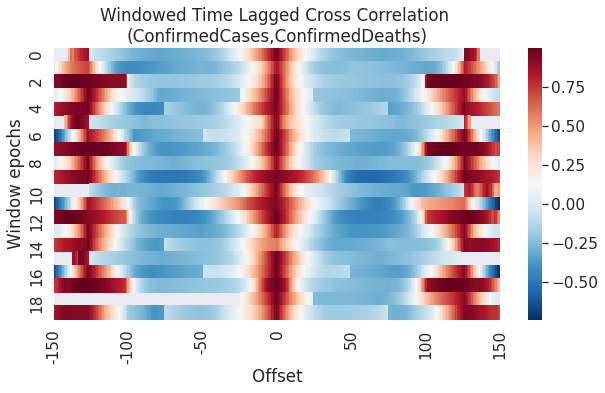

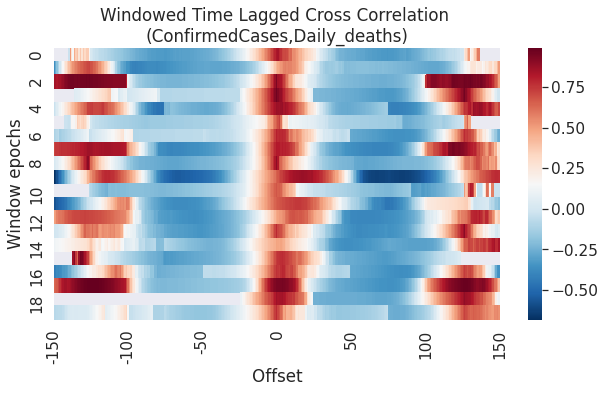

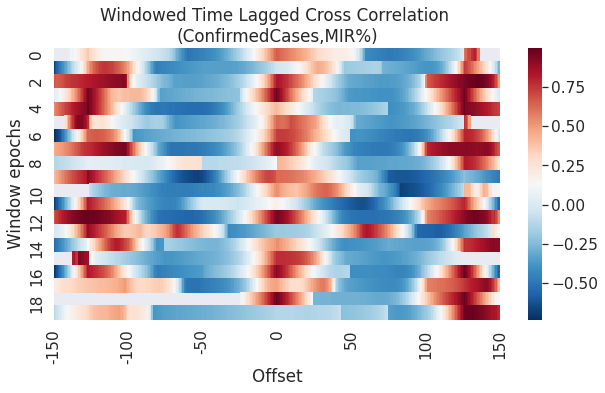

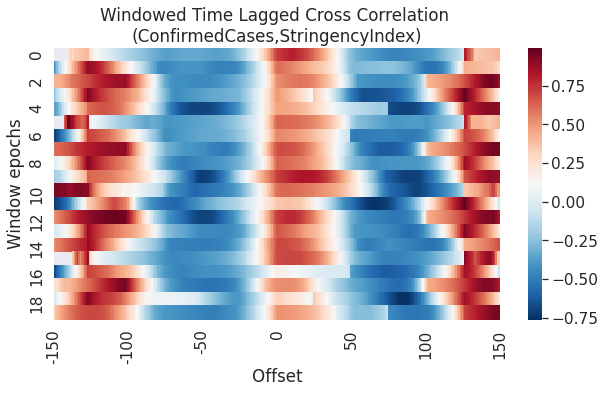

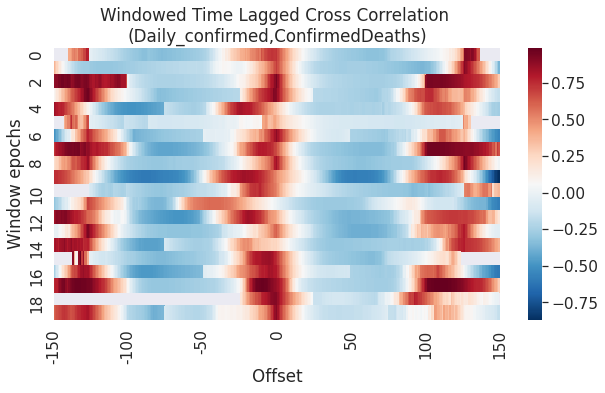

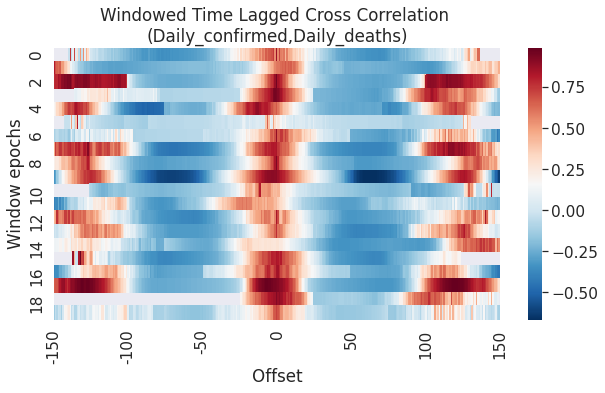

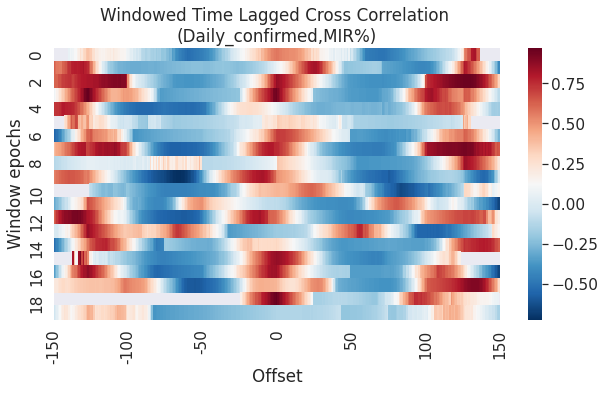

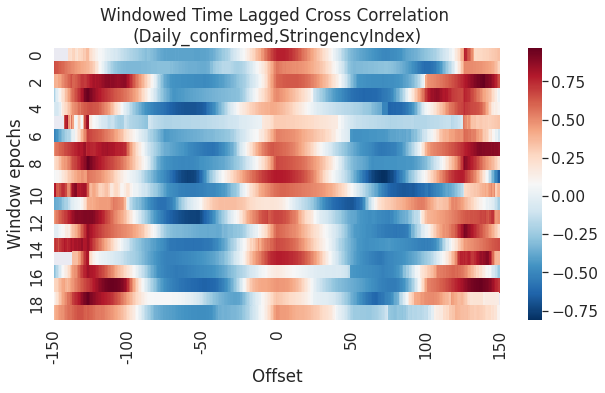

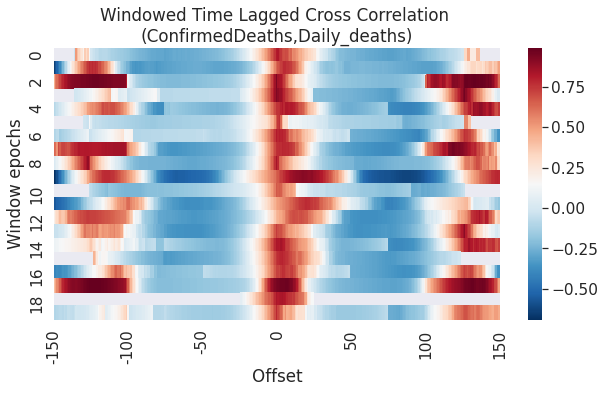

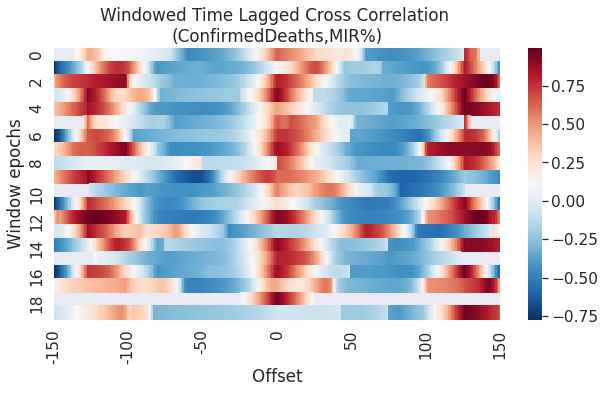

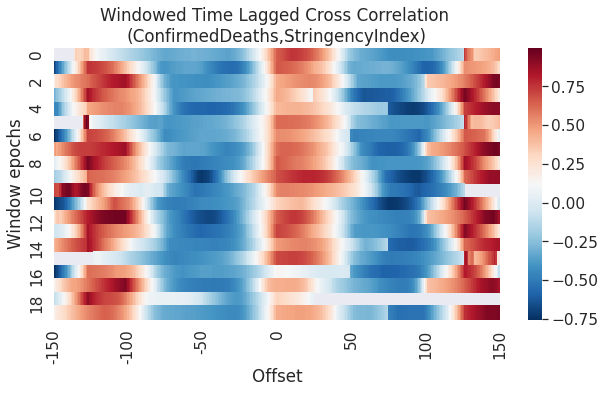

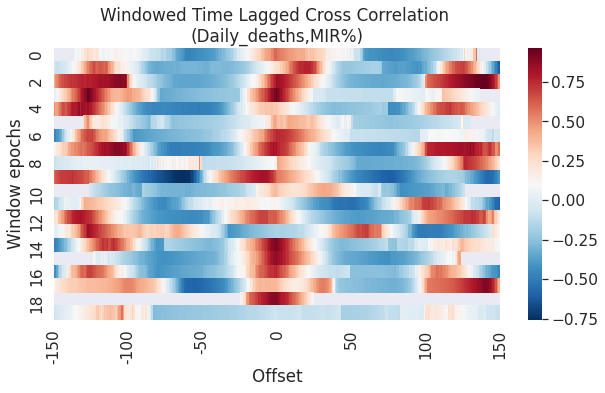

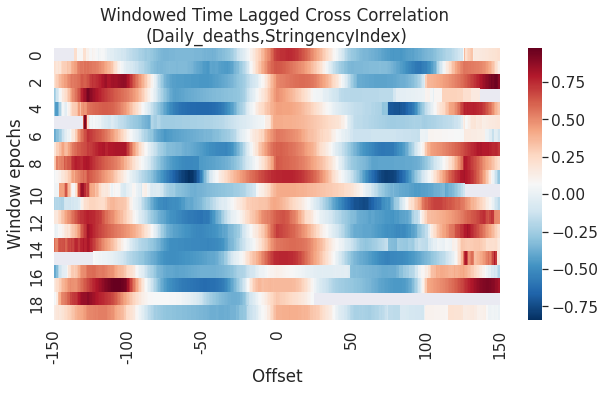

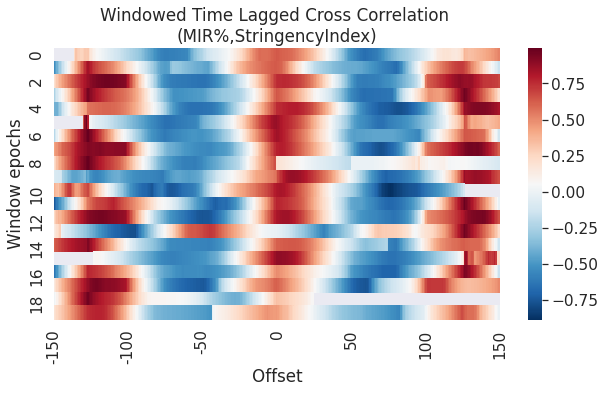

In [0]:
all_policies_WTCC(df,['CountryName','Class','Date','Cluster',
                      'C1_Flag','C2_Flag','C3_Flag','C4_Flag',
                      'C5_Flag','C6_Flag','C7_Flag','E3_Fiscal measures','E1_Flag','H1_Flag',
                      'E4_International support','C1','C2','C3','C4','C5',
                      'C6','C7','H1','C8','LegacyStringencyIndex','StringencyIndexForDisplay',
                      'LegacyStringencyIndexForDisplay','H5_Investment in vaccines',
                      'H4_Emergency investment in healthcare']+mov_policies)

#Failed Experiments due to lack of data

In [0]:
def edited_WTCC(df,var1,var2,seconds=5,fps=30,no_splits=20):
  samples_per_split = df.shape[0]/no_splits
  rss=[]
  for t in range(0, no_splits):
      d1 = df[var1].loc[(t)*samples_per_split:(t+1)*samples_per_split]
      d2 = df[var2].loc[(t)*samples_per_split:(t+1)*samples_per_split]
      rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
      rss.append(rs)
  rss = pd.DataFrame(rss)
  f,ax = plt.subplots(figsize=(10,5))
  sns.heatmap(rss,cmap='RdBu_r',ax=ax)
  ax.set(title=f'Windowed Time Lagged Cross Correlation \n('+str(var1)+','+str(var2)+')',xlim=[0,101], xlabel='Offset',ylabel='Window epochs')
  ax.set_xticks([0, 50, 100])
  #ax.set_xticklabels([-150, -100, -50, 0, 50, 100, 150]);

In [0]:
def country_wise_WTCC(df,exclude,country):
  df=df.loc[df['CountryName']==country]
  edited_WTCC(df,'ConfirmedDeaths','StringencyIndex',5,15,10)
  #all_policies_WTCC(df,exclude)

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:208: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


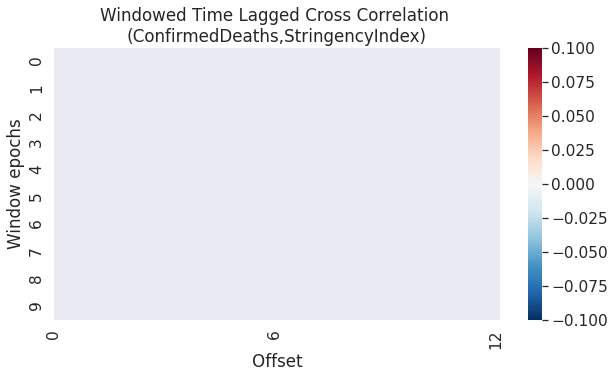

In [0]:
country_wise_WTCC(df,exclude+mov_policies,'Australia')

In [0]:
country_wise_WTCC(df,exclude+mov_policies,'Italy')

In [0]:
country_wise_WTCC(df,exclude+mov_policies,'India')

In [0]:
country_wise_WTCC(df,exclude+mov_policies,'Japan')

In [0]:
country_wise_WTCC(df,exclude+mov_policies,'South Korea')

In [0]:
country_wise_WTCC(df,exclude+mov_policies,'Sweden')

In [0]:
country_wise_WTCC(df,exclude+mov_policies,'United States')